In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 60.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=f116ccf3da21692603bfe5e3ce4a19c70a5a63581eaa61bee23342c27fcff5d6
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:

import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Membuat sparksession dan path

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("Logistic-Regression-Credit-Card-Fraud").getOrCreate()

In [ ]:
path = 'creditcard.csv'

In [ ]:
df = spark.read.format("csv").option("header","true")\
.option("inferSchema","true").load(path=path)

In [ ]:
df.describe

<bound method DataFrame.describe of DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: int]>

In [ ]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

fitur kolom


In [ ]:
feature_columns = [col for col in df.columns if col!='Class']
print(feature_columns)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Kumpulan data


In [ ]:
df_fraud=df.filter(df['Class'] == 1)
df_non_fraud=df.filter(df['Class'] == 0)
df_fraud_count=df_fraud.count()
df_non_fraud_count=df_non_fraud.count()
print('Voulume Data Penipuan：',df_fraud_count)
print('Volume data non penipuan：',df_non_fraud_count)

Voulume Data Penipuan： 94
Volume data non penipuan： 29705


# EDA ( Ekplolrasi dan analisis Data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


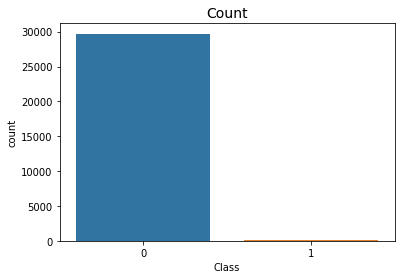

In [ ]:
sns.countplot('Class', data=df.toPandas())
plt.title('Count', fontsize=14)
plt.show()

Data nya diatas 250 rb

Partinjau Sepuluh baris pertama dari time , v1, v2 dan v3

In [ ]:
df.select('Time','V1','V2','V3','Amount','Class').show(10)

+----+------------------+-------------------+------------------+------+-----+
|Time|                V1|                 V2|                V3|Amount|Class|
+----+------------------+-------------------+------------------+------+-----+
| 0.0|  -1.3598071336738|-0.0727811733098497|  2.53634673796914|149.62|    0|
| 0.0|  1.19185711131486|   0.26615071205963|  0.16648011335321|  2.69|    0|
| 1.0| -1.35835406159823|  -1.34016307473609|  1.77320934263119|378.66|    0|
| 1.0|-0.966271711572087| -0.185226008082898|  1.79299333957872| 123.5|    0|
| 2.0| -1.15823309349523|  0.877736754848451|    1.548717846511| 69.99|    0|
| 2.0|-0.425965884412454|  0.960523044882985|  1.14110934232219|  3.67|    0|
| 4.0|  1.22965763450793|  0.141003507049326|0.0453707735899449|  4.99|    0|
| 7.0|-0.644269442348146|   1.41796354547385|   1.0743803763556|  40.8|    0|
| 7.0| -0.89428608220282|  0.286157196276544|-0.113192212729871|  93.2|    0|
| 9.0| -0.33826175242575|   1.11959337641566|  1.04436655157316|

Korelasi dalam data

<function matplotlib.pyplot.show>

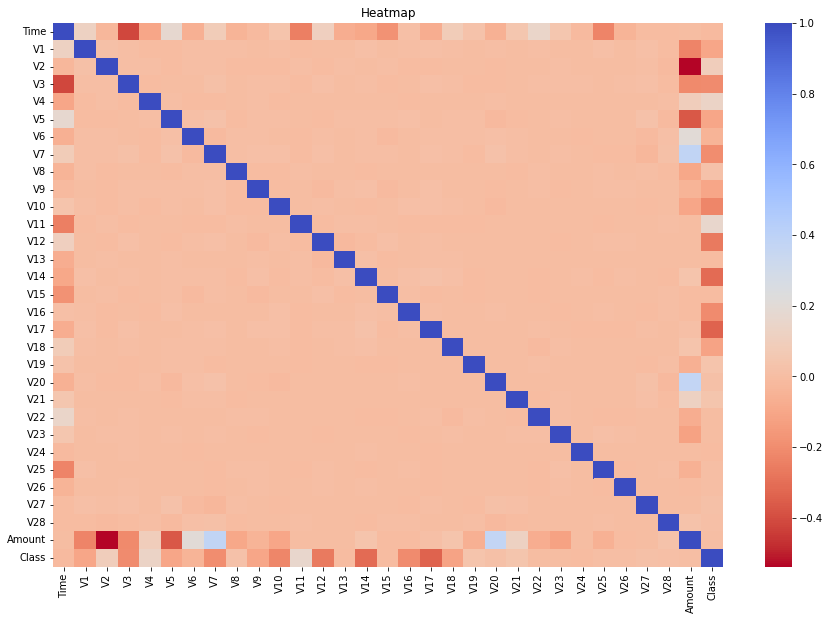

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.toPandas().corr(),cmap='coolwarm_r')
plt.title('Heatmap')
plt.show

melalui Data ini, Terdapat korelasi antara waktu dan data tidak penipuan 

Visualsasi Data waktu , penipuan dan non penipuan

Text(0.5, 1.0, 'Tidak Penipuan')

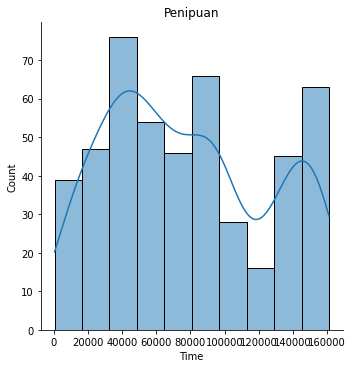

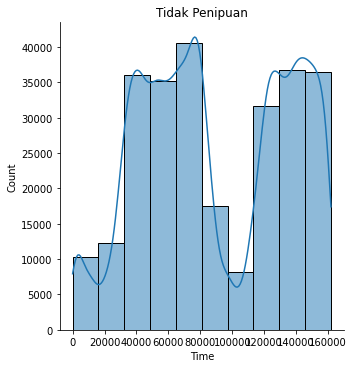

In [ ]:
sns.displot(x='Time',data=df_fraud.toPandas(),kde=True,bins=10)
plt.title('Penipuan')

sns.displot(x='Time',data=df_non_fraud.toPandas(),kde=True,bins=10)
plt.title('Tidak Penipuan')

Data non penipuan lebih teratur, sedangkan untuk penipuan rata rata

Gunakan fungsi sampel untuk mengambil sampel untuk membuat data non-penipuan untuk keseimbangan

In [ ]:
df_non_fraud=df_non_fraud.sample(df_fraud_count/df_non_fraud_count)

Volume data Penipuan

In [ ]:
df_non_fraud_count=df_non_fraud.count()
print('Volume data non penipuan：',df_non_fraud_count)

Volume data non penipuan： 90


Mengumpulkan data penipuan saat ini

In [ ]:
new_df=df_non_fraud.union(df_fraud)

Visualisasi

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


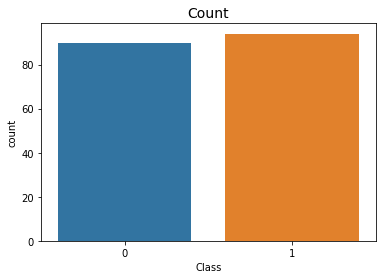

In [ ]:
sns.countplot('Class', data=new_df.toPandas())
plt.title('Count', fontsize=14)
plt.show()

Melihat data korelasi

<function matplotlib.pyplot.show>

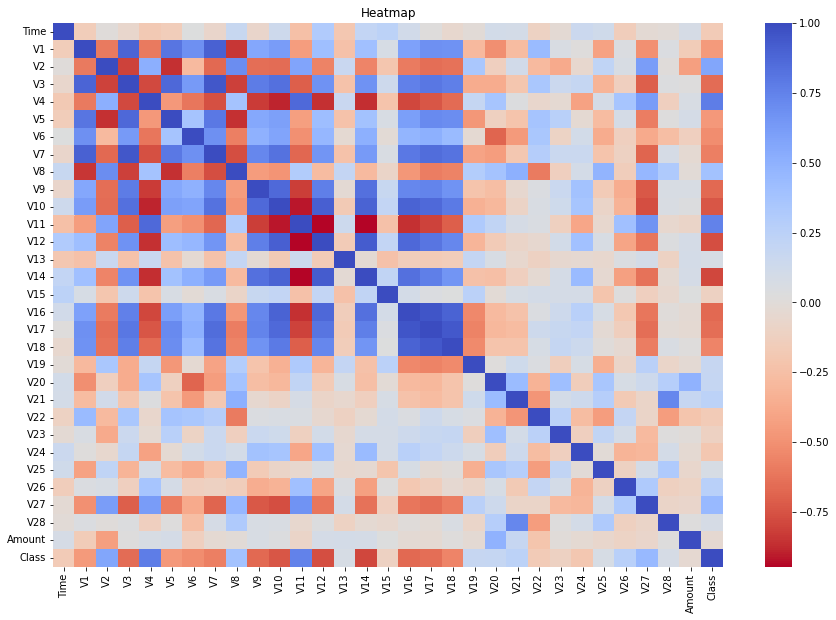

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_df.toPandas().corr(),cmap='coolwarm_r')
plt.title('Heatmap')
plt.show

Pembersihan data

In [ ]:
df_dropDuplicates=new_df.dropDuplicates()

In [ ]:
print('Menghapus Data Duplikat：',df_dropDuplicates.count())

Menghapus Data Duplikat： 184


Menghapus baris dan nilai yang tidak ada

In [ ]:
df_dropna=df_dropDuplicates.dropna()

In [ ]:
print('Menghapus baris dan nilai tidak ada ：',df_dropna.count())

Menghapus baris dan nilai tidak ada ： 184


Gunakan Kuartil untuk menghapus nilai palsu dan nilai outlier visualisasi batas interkuartil 

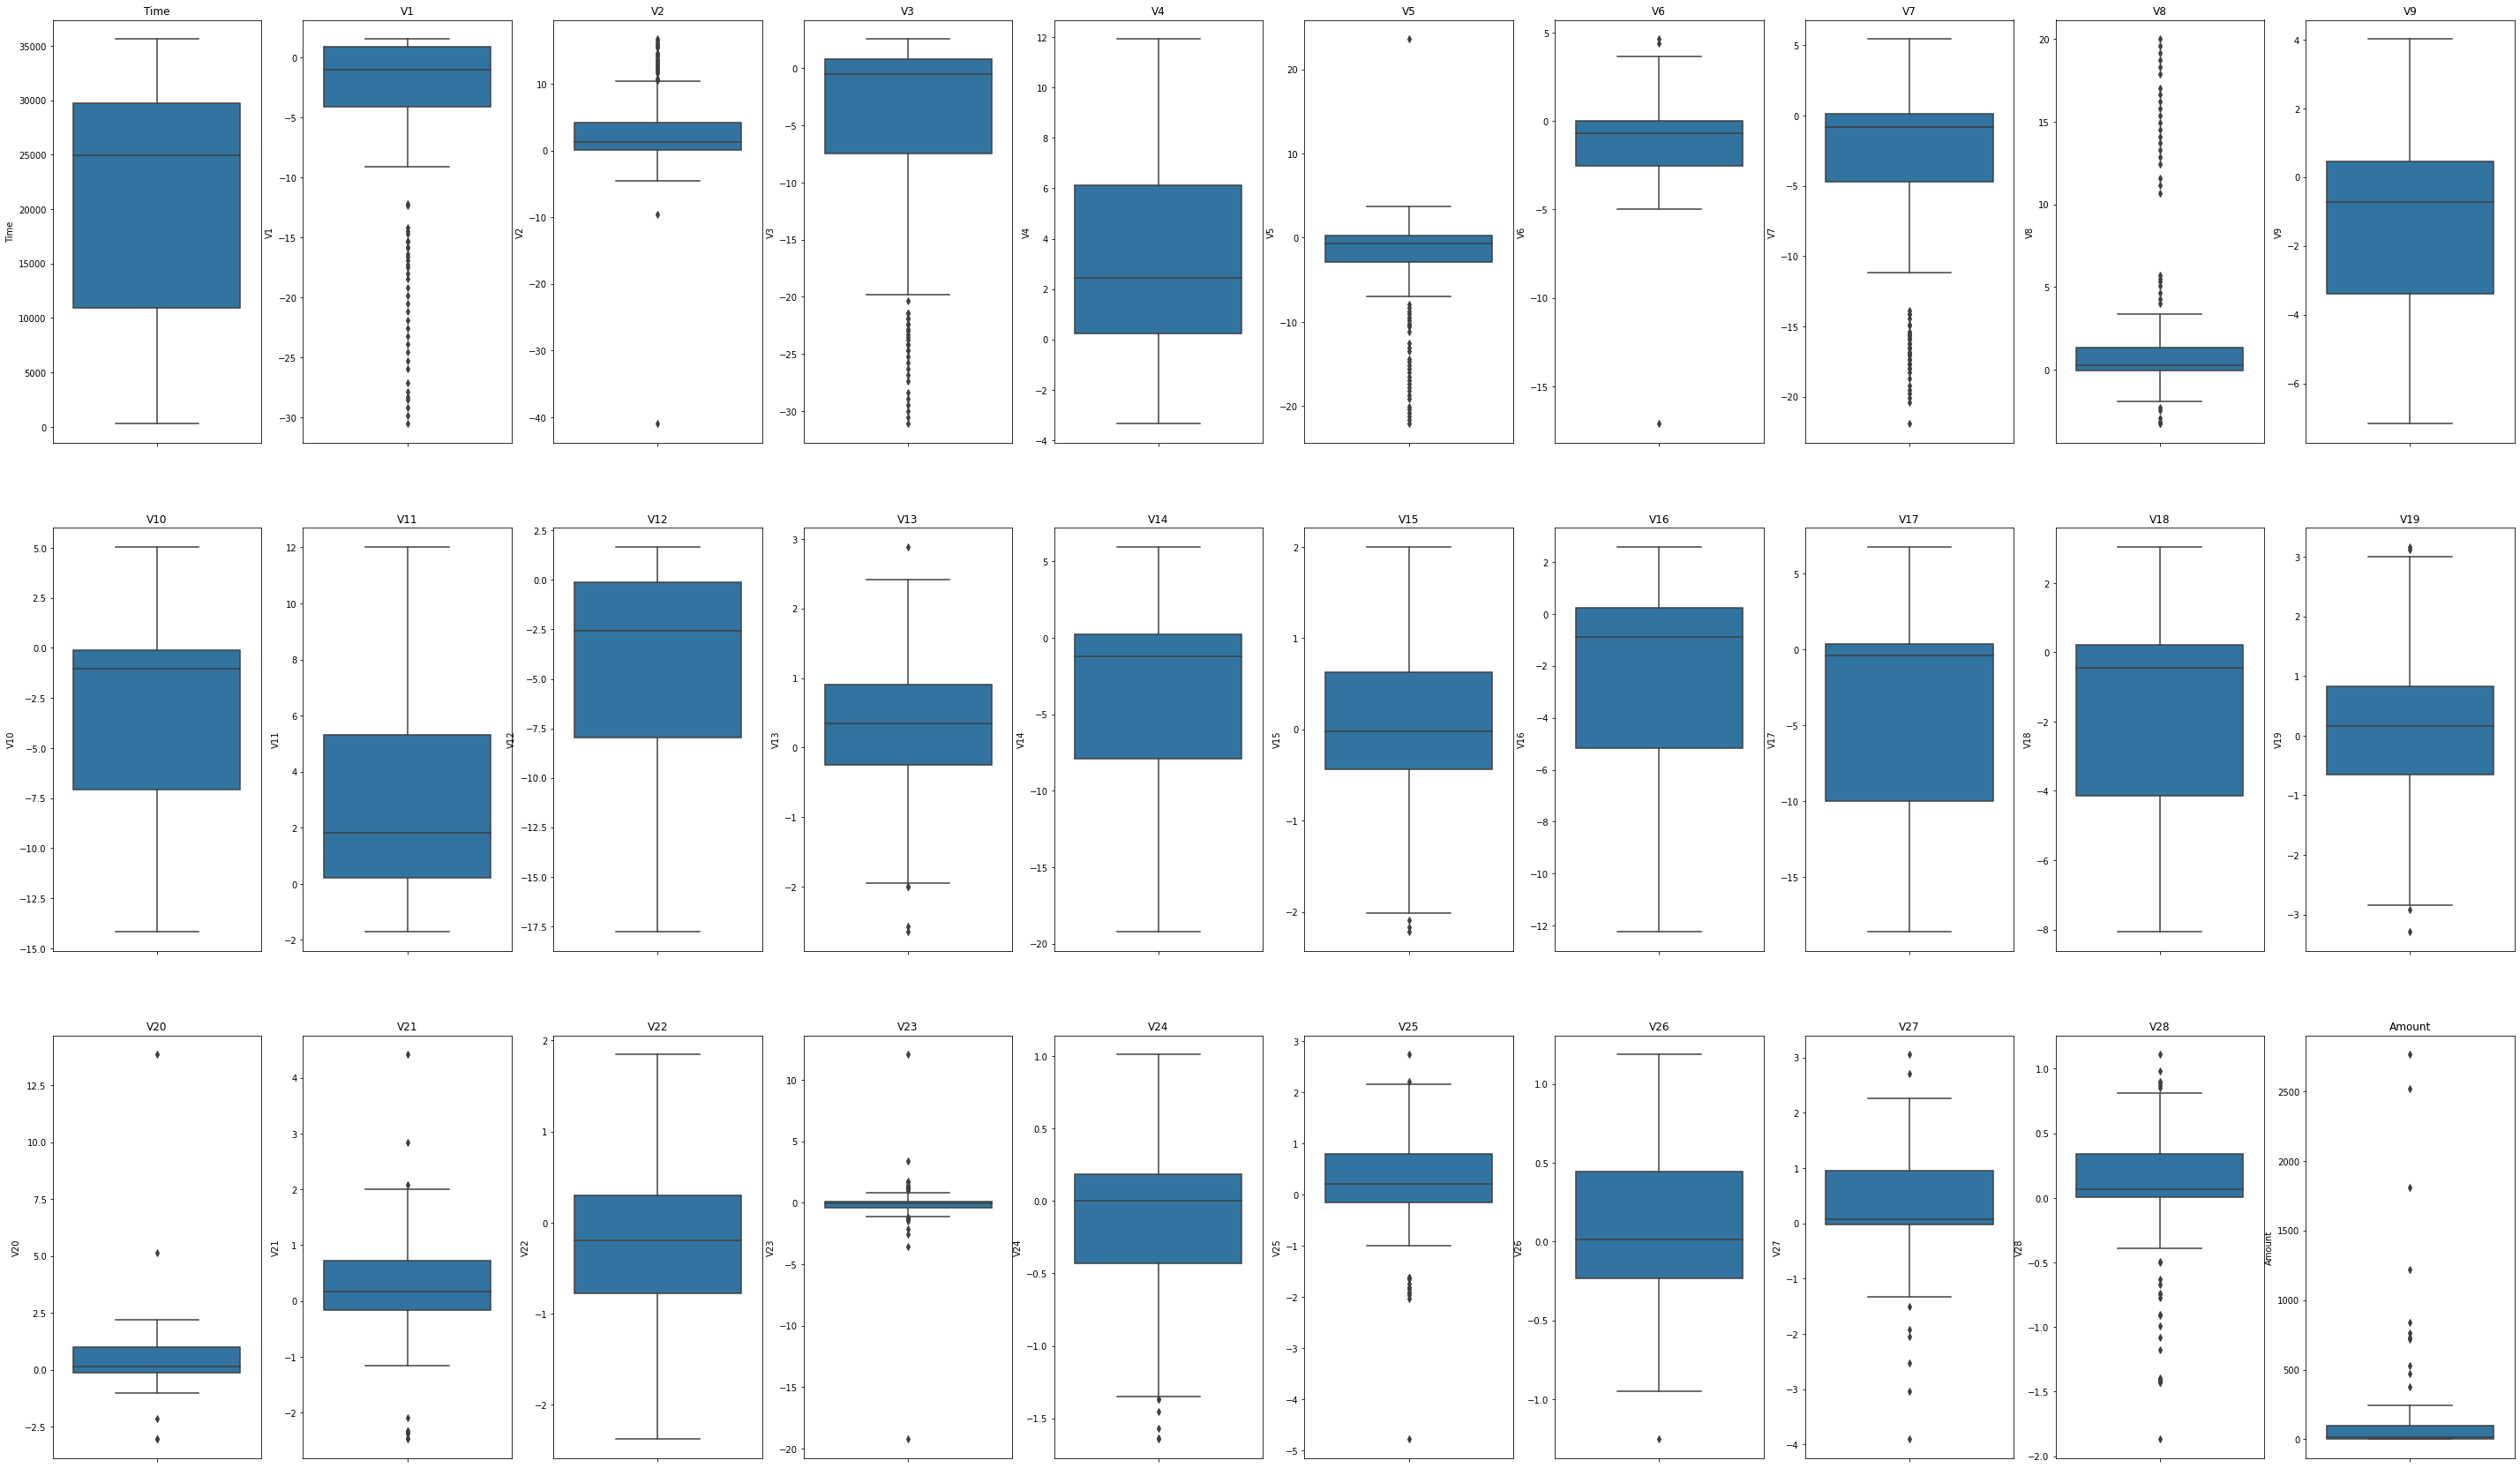

In [ ]:
bounds={}
fig,ax=plt.subplots(3,10, figsize=(50,30))
i=0
for col in feature_columns:
    plt.title(col)
    sns.boxplot( y=col,data=df_dropna.toPandas(),ax=ax[i//10][i%10],whis=1.5)
    ax[i//10][i%10].set_title(col)
    i=i+1
    quantiles = df_dropna.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

Filter data yang melebihi nilai batas

In [ ]:
for col in feature_columns:
    df_filtered=df_dropna.filter(df_dropna[col] >= bounds[col][0]).filter(df_dropna[col] <= bounds[col][1])

In [ ]:
print('jumlah data setelah menghapus nilai kesalahan dan outlier：',df_filtered.count())

jumlah data setelah menghapus nilai kesalahan dan outlier： 171




```
```

## Machine Learning: Logistic Regression

Vektor Assembler

In [ ]:
assembler=VectorAssembler(inputCols=feature_columns, outputCol="Features")  

In [ ]:
df_assembled = assembler.transform(df_filtered)

In [ ]:
df_assembled.select('Time','Features','Class').show(10)

+-----+--------------------+-----+
| Time|            Features|Class|
+-----+--------------------+-----+
|28658|[28658.0,1.145354...|    0|
|29772|[29772.0,1.202564...|    0|
|28005|[28005.0,1.285603...|    0|
|24759|[24759.0,1.169121...|    0|
| 2550|[2550.0,-1.055610...|    0|
| 4471|[4471.0,-5.006940...|    0|
|29637|[29637.0,1.361017...|    0|
|13392|[13392.0,1.193572...|    0|
|  283|[283.0,-0.5299957...|    0|
|16652|[16652.0,1.164412...|    0|
+-----+--------------------+-----+
only showing top 10 rows



Normalisasi fitur (normalisasi standar deviasi) dan output di kolom Features_scaled

In [ ]:
standardScaler = StandardScaler(inputCol="Features", outputCol="Features_scaled")

In [ ]:
df_scaled = standardScaler.fit(df_assembled).transform(df_assembled)

In [ ]:
df_scaled.select("Features", "Features_scaled").show(10)

+--------------------+--------------------+
|            Features|     Features_scaled|
+--------------------+--------------------+
|[28658.0,1.145354...|[2.66771770616502...|
|[29772.0,1.202564...|[2.77141780821918...|
|[28005.0,1.285603...|[2.60693120110097...|
|[24759.0,1.169121...|[2.30476734897550...|
|[2550.0,-1.055610...|[0.23737456035734...|
|[4471.0,-5.006940...|[0.41619672915988...|
|[29637.0,1.361017...|[2.75885091972967...|
|[13392.0,1.193572...|[1.24663533815905...|
|[283.0,-0.5299957...|[0.02634392179652...|
|[16652.0,1.164412...|[1.55010242316491...|
+--------------------+--------------------+
only showing top 10 rows



Penggunaan Sklearn untuk segmentasi

In [ ]:
train_data, test_data = df_scaled.randomSplit([.8,.2])


Logisitc Regression

In [ ]:
lr = LogisticRegression(featuresCol='Features_scaled', labelCol="Class", predictionCol='Prediction', 
                               maxIter=50) 

In [ ]:
lr_model = lr.fit(train_data)

Dengan menggunakan Model kita prediksi hasil 

In [ ]:
predictions = lr_model.transform(test_data)

Hasil 

In [ ]:
result = predictions.select("Class","Prediction")

In [ ]:
result.show()

+-----+----------+
|Class|Prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



akurasi, regresi, f1score, dan akurasi sistem

In [ ]:
TP = result.filter(result['Prediction'] == 1).filter(result['Class'] == 1).count()
FN = result.filter(result['Prediction'] == 0).filter(result['Class'] == 1).count()
TN = result.filter(result['Prediction'] == 0).filter(result['Class'] == 0).count()
FP = result.filter(result['Prediction'] == 1).filter(result['Class'] == 0).count()

In [ ]:
precision = TP/(TP+FP) 
recall = TP/(TP+FN)
F1 =(2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+TN+FP+FN)

In [ ]:
print("precision:",precision)
print("recall:",recall)
print("F1:",F1)
print("accuracy:",accuracy)

precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
accuracy: 0.9696969696969697


Nilai Missed data penipuan

In [ ]:
missed=FN/(FN+TN)
print('missed:',missed) 

missed: 0.037037037037037035


Kurva Roc

(-0.01, 1.0, 0.0, 1.0)

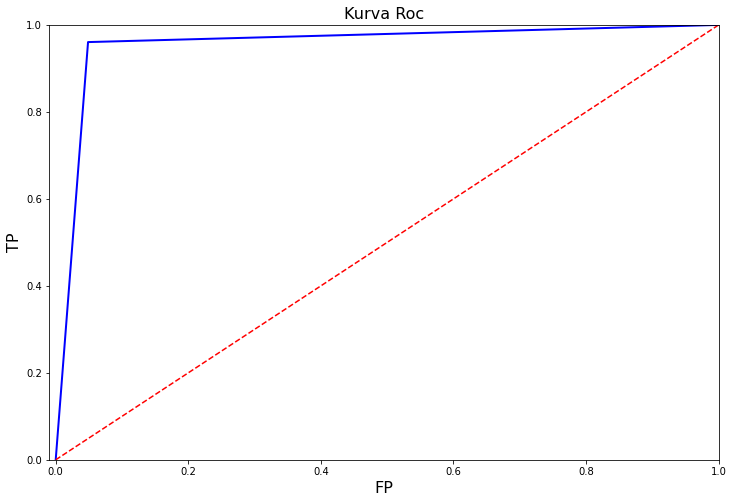

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(result.toPandas()['Class'], result.toPandas()['Prediction'])

plt.figure(figsize=(12,8))
plt.title('Kurva Roc', fontsize=16)
plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FP', fontsize=16)
plt.ylabel('TP', fontsize=16)
plt.axis([-0.01,1,0,1])